In [1]:
import random
from joblib import dump, load

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

In [2]:
#forest_grid = load('forest_grid.model')

In [3]:
df = pd.read_csv('waitlist_kidney_brazil_prepared_sensitive.csv', encoding='iso-8859-1')
df.head()

,date_registered,age_registered,dialysis_session_count,sex,race,underlying_disease,diabetes,chagas,blood_type,transfusion_count,gestation,prior_transplant,c_pra,hla_a1,hla_a2,hla_b1,hla_b2,hla_dr1,hla_dr2,dr_00,b_00,a_00,anti_hbc,anti_hcv,hbs_ag,event,days_waiting
0,2017-06-29,67,1.0,M,Branca,other,True,False,A,0,False,False,0,1,26,44,51,3,7,heterozygous,heterozygous,heterozygous,False,False,False,waiting,392
1,2008-11-03,58,4.0,M,Branca,diabetes,False,False,A,0,False,False,0,1,24,18,35,11,0,homozygous,heterozygous,heterozygous,False,False,False,died_waiting,2066
2,2010-07-13,51,2.0,M,Branca,hypertension,True,False,O,0,False,False,64,24,25,14,18,1,15,heterozygous,heterozygous,heterozygous,False,False,False,removed,365
3,2011-10-03,52,17.0,M,Branca,diabetes,False,False,O,0,False,True,2,24,25,14,18,1,15,heterozygous,heterozygous,heterozygous,False,False,False,removed,365
4,2006-07-05,67,68.0,M,Parda,hypertension,True,False,A,0,False,False,0,24,68,14,27,13,15,heterozygous,heterozygous,heterozygous,False,False,False,died_waiting,194


In [4]:
df['date_registered'] = pd.to_datetime(df['date_registered'])
df_clean = df[df['event'] == 'transplanted']
df_clean = df_clean.drop(columns=['event'])
df_clean['date_transplanted'] = df_clean['date_registered'] + pd.to_timedelta(df_clean['days_waiting'], 'days')
df_clean['date_registered'] = df_clean['date_registered'].astype(int) / (1e9 * 3600 * 24)
df_clean['idx'] = df_clean.index
df_onehot = pd.get_dummies(df_clean, columns=['sex', 'race', 'underlying_disease', 'blood_type', 'dr_00', 'b_00', 'a_00'], drop_first=True)
df_onehot['race'] = df_clean['race']
N = df_onehot.shape[0]
N_train = N * 80 // 100
df_onehot.sort_values(by='date_registered', inplace=True, ignore_index=True)
df_onehot, df_test = df_onehot.iloc[:N_train], df_onehot[N_train:]

In [5]:
random.seed(1729)

pairs = set()
while len(pairs) < 200000:
    a = random.randint(1, df_onehot.shape[0] - 1)
    b = random.randint(max(0, a - 1000), a-1)
    pairs.add((a, b))

In [6]:
a = [i for (i, _) in pairs]
b = [i for (_, i) in pairs]

df_a = df_onehot.iloc[a]
df_a.columns = df_a.columns + '_a'
df_b = df_onehot.iloc[b]
df_b.columns = df_b.columns + '_b'

df_a.index = df_b.index = range(len(pairs))

df_cross = pd.concat((df_a, df_b), axis=1)
df_cross.head()

,date_registered_a,age_registered_a,dialysis_session_count_a,diabetes_a,chagas_a,transfusion_count_a,gestation_a,prior_transplant_a,c_pra_a,hla_a1_a,hla_a2_a,hla_b1_a,hla_b2_a,hla_dr1_a,hla_dr2_a,anti_hbc_a,anti_hcv_a,hbs_ag_a,days_waiting_a,date_transplanted_a,idx_a,sex_M_a,race_Branca_a,race_Negra_a,race_Parda_a,underlying_disease_glomerulonephritis_a,underlying_disease_hypertension_a,underlying_disease_other_a,underlying_disease_pyelonephritis_a,blood_type_AB_a,blood_type_B_a,blood_type_O_a,dr_00_homozygous_a,b_00_homozygous_a,a_00_homozygous_a,race_a,date_registered_b,age_registered_b,dialysis_session_count_b,diabetes_b,chagas_b,transfusion_count_b,gestation_b,prior_transplant_b,c_pra_b,hla_a1_b,hla_a2_b,hla_b1_b,hla_b2_b,hla_dr1_b,hla_dr2_b,anti_hbc_b,anti_hcv_b,hbs_ag_b,days_waiting_b,date_transplanted_b,idx_b,sex_M_b,race_Branca_b,race_Negra_b,race_Parda_b,underlying_disease_glomerulonephritis_b,underlying_disease_hypertension_b,underlying_disease_other_b,underlying_disease_pyelonephritis_b,blood_type_AB_b,blood_type_B_b,blood_type_O_b,dr_00_homozygous_b,b_00_homozygous_b,a_00_homozygous_b,race_b
0,13629.0,59,28.0,True,False,0,False,False,0,2,3,35,40,11,13,False,False,False,700,2009-03-26,5875,True,True,False,False,True,False,False,False,False,True,False,False,False,False,Branca,13371.0,40,3.0,True,False,0,False,False,0,1,2,35,44,8,14,False,False,False,1332,2010-04-04,11918,False,True,False,False,False,False,True,False,False,False,True,False,False,False,Branca
1,14463.0,58,6.0,False,False,0,False,False,0,2,30,14,45,13,15,False,False,False,847,2011-12-02,2087,True,True,False,False,False,False,False,False,False,False,False,False,False,False,Branca,14194.0,18,1.0,True,False,0,False,False,0,2,3,7,39,11,15,False,False,False,1198,2012-02-22,46830,True,False,True,False,False,False,True,False,False,True,False,False,False,False,Negra
2,15614.0,42,22.0,True,False,0,False,False,0,2,68,14,53,10,13,False,False,False,290,2013-07-18,21870,True,True,False,False,False,False,True,False,False,False,True,False,False,False,Branca,15562.0,26,10.0,True,False,0,False,False,0,2,2,15,15,14,13,False,False,False,31,2012-09-10,9896,False,True,False,False,False,False,True,False,False,False,True,False,False,False,Branca
3,13063.0,41,5.0,True,False,0,False,False,0,11,25,7,18,4,16,False,False,False,2402,2012-05-05,26995,True,True,False,False,True,False,False,False,False,False,False,False,False,False,Branca,12951.0,57,15.0,True,False,0,False,False,0,1,2,18,35,11,13,False,False,False,668,2007-04-16,23707,True,False,False,True,False,True,False,False,False,False,True,False,False,False,Parda
4,11248.0,60,5.0,True,False,0,False,False,0,0,74,42,15,8,13,False,False,False,1273,2004-04-13,37961,True,False,False,True,True,False,False,False,False,False,True,False,False,True,Parda,11107.0,41,1.0,True,False,0,False,False,0,1,32,58,15,13,15,False,False,False,781,2002-07-20,4735,True,False,False,True,False,True,False,False,False,False,False,False,False,False,Parda


In [7]:
df_cross['transplanted_first'] = df_cross['date_transplanted_a'] < df_cross['date_transplanted_b']
target = 'transplanted_first'
_meta = ['idx_a', 'idx_b','days_waiting_a', 'days_waiting_b', 'date_transplanted_a', 'date_transplanted_b', 'race_a', 'race_b']
X, y, meta = df_cross.drop(columns=[target, *_meta]), df_cross[target], df_cross[_meta]

In [8]:
N = X.shape[0]
N_train = N * 80 // 100

X_train, X_test = X.iloc[:N_train], X.iloc[N_train:]
y_train, y_test = y.iloc[:N_train], y.iloc[N_train:]
meta_train, meta_test = meta.iloc[:N_train], meta.iloc[N_train:]

In [9]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(
    n_estimators=1500,
    min_samples_split=2,
    max_features='sqrt',
    random_state=1729,
    n_jobs=-1
)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1500, n_jobs=-1, random_state=1729)

In [10]:
y_pred = classifier.predict(X_test)

/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


array([[<Axes: title={'center': 'accuracy'}, xlabel='race_a'>,
        <Axes: title={'center': 'precision'}, xlabel='race_a'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='race_a'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='race_a'>,
        <Axes: title={'center': 'selection rate'}, xlabel='race_a'>,
        <Axes: title={'center': 'count'}, xlabel='race_a'>],
       [<Axes: xlabel='race_a'>, <Axes: xlabel='race_a'>,
        <Axes: xlabel='race_a'>]], dtype=object)

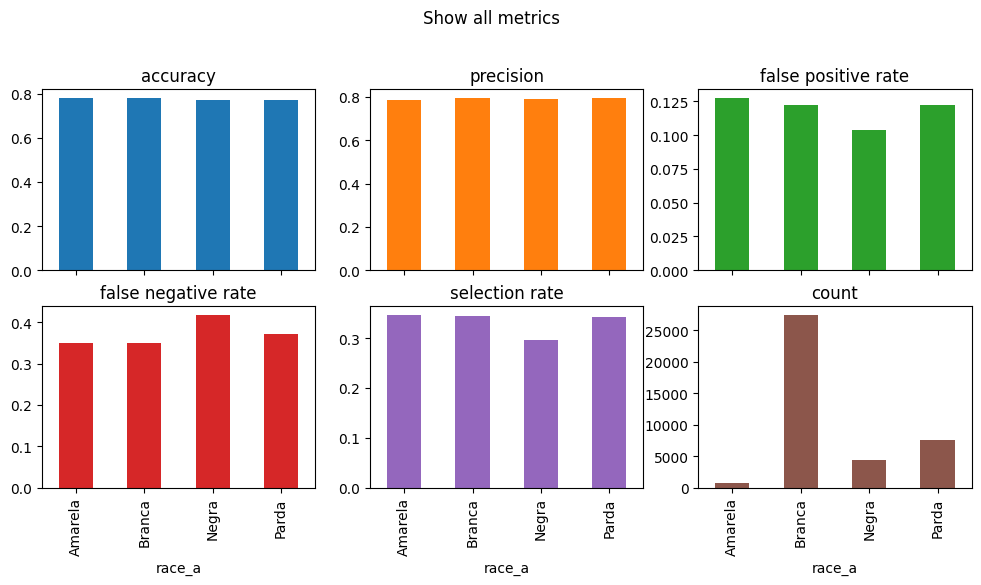

In [11]:
from sklearn.metrics import accuracy_score, precision_score
from fairlearn.metrics import MetricFrame, false_positive_rate, false_negative_rate, selection_rate, count

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}

metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=df_cross['race_a'].loc[y_test.index]
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [13]:
abs(
    y_pred[(df_cross['sex_M_a'].loc[y_test.index] != True) & (y_test == True)].mean() -
    y_pred[(df_cross['sex_M_a'].loc[y_test.index] == True) & (y_test == True)].mean()
) / 2
+ abs(
    y_pred[(df_cross['sex_M_a'].loc[y_test.index] != True) & (y_test == False)].mean() -
    y_pred[(df_cross['sex_M_a'].loc[y_test.index] == True) & (y_test == False)].mean()
) / 2

0.014781779279099717

In [14]:
abs(
    y_test[(df_cross['sex_M_a'].loc[y_test.index] != True) & (y_pred == True)].mean() -
    y_test[(df_cross['sex_M_a'].loc[y_test.index] == True) & (y_pred == True)].mean()
) / 2
+ abs(
    y_test[(df_cross['sex_M_a'].loc[y_test.index] != True) & (y_pred == False)].mean() -
    y_test[(df_cross['sex_M_a'].loc[y_test.index] == True) & (y_pred == False)].mean()
) / 2

0.000636900607996857

In [15]:
abs(
    y_pred[(df_cross['race_a'].loc[y_test.index] != 'Branca') & (y_test == True)].mean() -
    y_pred[(df_cross['race_a'].loc[y_test.index] == 'Branca') & (y_test == True)].mean()
) / 2
+ abs(
    y_pred[(df_cross['race_a'].loc[y_test.index] != 'Branca') & (y_test == False)].mean() -
    y_pred[(df_cross['race_a'].loc[y_test.index] == 'Branca') & (y_test == False)].mean()
) / 2

0.003063280369856161

In [16]:
abs(
    y_test[(df_cross['race_a'].loc[y_test.index] != 'Branca') & (y_pred == True)].mean() -
    y_test[(df_cross['race_a'].loc[y_test.index] == 'Branca') & (y_pred == True)].mean()
) / 2
+ abs(
    y_test[(df_cross['race_a'].loc[y_test.index] != 'Branca') & (y_pred == False)].mean() -
    y_test[(df_cross['race_a'].loc[y_test.index] == 'Branca') & (y_pred == False)].mean()
) / 2

0.007939829120939143